In [21]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
import matplotlib.colors as col
import ROOT 

In [10]:
msc_overlay_run1 = uproot.open("~/NuCCanalyser/NuCC_overlay.root")
msc_overlay_run2 = uproot.open("~/NuCCanalyser/NuCC_overlay.root")
msc_overlay_run3 = uproot.open("~/NuCCanalyser/NuCC_overlay.root")
msc_overlay_run1 = msc_overlay_run1['NuCCanalyzer/Daughters']
msc_overlay_run2 = msc_overlay_run2['NuCCanalyzer/Event']
msc_overlay_run3 = msc_overlay_run3['trajmcsntuple/tree']

In [32]:
df_ovr = msc_overlay_run1.pandas.df([
   'track_is_muon_candidate', 'mcs_trackLength_rm10', 'mcs_trackMom_MuFwd_rm10', 'mcs_trackMomErr_MuFwd_rm10', 
    'track_range_mom_mu', "mc_neutrino","track_score","vtx_distance","track_chi2_proton",
    "track_chi2_muon","track_length","generation","mc_pdg",
])

df_ovr1 = msc_overlay_run2.pandas.df([
   'nu_score', 'nu_flash_chi2','nu_mu_cc_selected',"mc_nu_pdg","daughters_start_contained","nu_contained","mc_nu_vtx_distance"
])

df_ovr2 = msc_overlay_run3.pandas.df([
    'simLength', 'simMatchPurity', 
])

muon_candidate_selection = "track_score>0.90 &\
                            vtx_distance<4.0 &\
                            track_chi2_proton>60.0 &\
                            track_chi2_muon<30.0 &\
                            (track_chi2_proton/track_chi2_muon)>7.0 &\
                            generation==2 &\
                            track_length>5"
event_selection = "mc_nu_pdg==14 &\
                   (nu_flash_chi2<10.0 | nu_score>0.25) &\
                   daughters_start_contained &\
                   nu_contained &\
                   longest_muon_candidate_length==track_length &\
                   nu_score>0.06"

nuScore_ovrl = msc_overlay_run2.array("nu_score")
fmScore_ovrl = msc_overlay_run2.array("nu_flash_chi2")
mcnupdg_ovrl = msc_overlay_run2.array("mc_nu_pdg")
daughters_start_contained_ovrl = msc_overlay_run2.array("daughters_start_contained")
nu_contained = msc_overlay_run2.array("nu_contained")
track_length = msc_overlay_run1.array("track_length")

cut_ovrl = (mcnupdg_ovrl == 14)&(nuScore_ovrl > 0.06)&((fmScore_ovrl < 10.0)|(nuScore_ovrl>0.25))&\
           (daughters_start_contained_ovrl)&(nu_contained)

label_ovrl = "BNB Overlay Run1"
trkLength_ovrl = msc_overlay_run1.array("mcs_trackLength_rm10")
trkMom_MuFwd_ovrl = msc_overlay_run1.array("mcs_trackMom_MuFwd_rm10")
trkMomErr_MuFwd_ovrl = msc_overlay_run1.array("mcs_trackMomErr_MuFwd_rm10")
trkMom_RangeMu_ovrl = msc_overlay_run1.array("track_range_mom_mu")
trkIsContained_ovrl = msc_overlay_run1.array("track_is_muon_candidate")

selection_ovrl = (trkIsContained_ovrl==1)&(trkLength_ovrl>100)&(trkMomErr_MuFwd_ovrl<7.5)&((trkMom_MuFwd_ovrl-trkMom_RangeMu_ovrl)>-0.2)
mcscont_ovrl = trkMom_MuFwd_ovrl[selection_ovrl]
rngcont_ovrl = trkMom_RangeMu_ovrl[selection_ovrl]

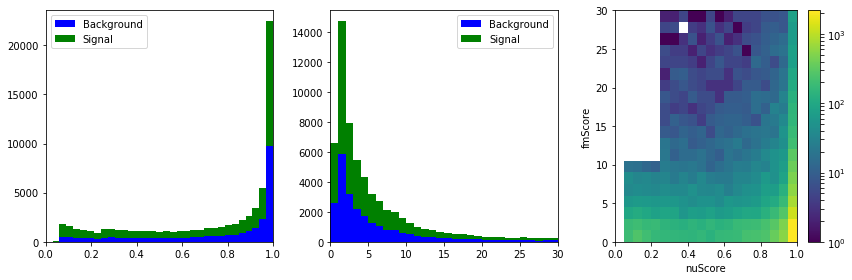

Purity: 4.00%


In [37]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

cut = ((df_ovr1.nu_mu_cc_selected)&\
      (df_ovr1.mc_nu_pdg == 14)&\
      (df_ovr1.nu_score > 0.06)&\
      ((df_ovr1.nu_flash_chi2 < 10.0)|(df_ovr1.nu_score>0.25))&\
      (df_ovr1.daughters_start_contained)&\
      (df_ovr1.nu_contained)&\
      (df_ovr.track_length>20.0)&\
                            (df_ovr.track_score>0.90)&\
                            (df_ovr.vtx_distance<4.0)&\
                            (df_ovr.track_chi2_proton>60.0)&\
                            (df_ovr.track_chi2_muon<30.0)&\
                            (df_ovr.generation == 2)&\
                            (df_ovr.track_length>5)&\
                            ((df_ovr.track_chi2_proton/df_ovr.track_chi2_muon)>7.0))

query_event = (cut &\
              (df_ovr1.mc_nu_vtx_distance<5) &\
              (abs(df_ovr.mc_pdg)==13))

"""Instead of 0.06 move it to 0.15 for nu_score"""

bins = np.linspace(0, 1, 34)
x = bins[:-1] + np.diff(bins) / 2
hb, _ = np.histogram(df_ovr1.nu_score[query_event], bins=bins)#~cut
ax1.bar(x, hb, width=np.diff(bins), color='blue', label='Background')
hs, _ = np.histogram(df_ovr1.nu_score[cut], bins=bins)
ax1.bar(x, hs, bottom=hb, width=np.diff(bins), color='green', label='Signal')
ax1.set_xlim(0, 1)
ax1.legend(loc='upper left')

bins = np.linspace(0, 30, 31)
x = bins[:-1] + np.diff(bins) / 2
hb, _ = np.histogram(df_ovr1.nu_flash_chi2[query_event], bins=bins)
ax2.bar(x, hb, width=np.diff(bins), color='blue', label='Background')
hs, _ = np.histogram(df_ovr1.nu_flash_chi2[cut], bins=bins)
ax2.bar(x, hs, bottom=hb, width=np.diff(bins), color='green', label='Signal')
ax2.set_xlim(0, 30)
ax2.legend(loc='upper right')

_, _, _, h2 = ax3.hist2d(df_ovr1.nu_score[query_event], df_ovr1.nu_flash_chi2[query_event],
                         bins=(20,20), range=[[0,1],[0,30]], norm=col.LogNorm())
ax3.set_xlabel('nuScore')
ax3.set_ylabel('fmScore')
fig.colorbar(h2, ax=ax3)

plt.tight_layout()
plt.show()

print('Purity: %1.2f%%' % (100.0 * np.sum(cut) / len(df_ovr1)))

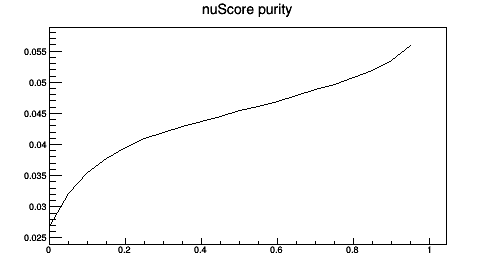

In [38]:
xb = np.linspace(0, 1, 21)[:-1]

beta = ROOT.TCanvas("beta","2dplot",200,10,500,300)
dy = ROOT.TGraph()
dy.SetTitle("nuScore purity")
for i,nu_cut in enumerate(xb): 
    pcut = (df_ovr1.nu_score>nu_cut)
    alpha = np.sum(pcut&query_event)
    alpha = float(alpha)
    gamma = np.sum(pcut)
    gamma = float(gamma)
    purity =  alpha/gamma
    #efficiency = np.sum(pcut&cut) / np.sum(cut)
    #purity = np.sum(pcut&cut) / np.sum(pcut)
    
    dy.SetPoint(i,nu_cut,purity)
     
dy.Draw()
beta.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: beta


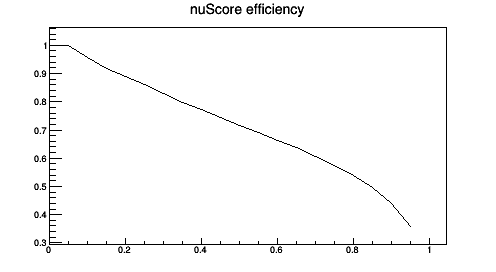

In [23]:
xb = np.linspace(0, 1, 21)[:-1]

beta = ROOT.TCanvas("beta","2dplot",200,10,500,300)
dy = ROOT.TGraph()
dy.SetTitle("nuScore efficiency")
for i,nu_cut in enumerate(xb): 
    pcut = (df_ovr1.nu_score>nu_cut)
    alpha = np.sum(pcut&cut)#cut
    alpha = float(alpha)
    gamma = np.sum(cut)#cut
    gamma = float(gamma)
    efficiency =  alpha/gamma
    #efficiency = np.sum(pcut&cut) / np.sum(cut)
    #purity = np.sum(pcut&cut) / np.sum(pcut)
    
    dy.SetPoint(i,nu_cut,efficiency)
     
dy.Draw()
beta.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: beta


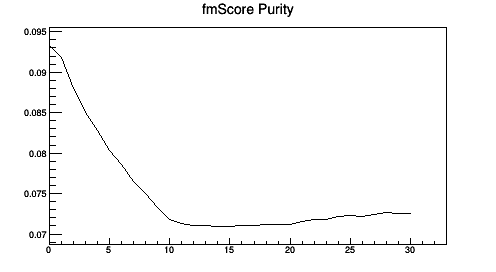

In [24]:
yb = np.linspace(0, 30, 31)

beta = ROOT.TCanvas("beta","2dplot",200,10,500,300)
dy = ROOT.TGraph()
dy.SetTitle("fmScore Purity")
for i,fm_cut in enumerate(yb): 
    pcut = (df_ovr1.nu_flash_chi2>fm_cut)
    alpha = np.sum(pcut&cut)
    alpha = float(alpha)
    gamma = np.sum(pcut)
    gamma = float(gamma)
    purity =  alpha/gamma
    #efficiency = np.sum(pcut&cut) / np.sum(cut)
    #purity = np.sum(pcut&cut) / np.sum(pcut)
    
    dy.SetPoint(i,fm_cut,purity)
     
dy.Draw()
beta.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: beta


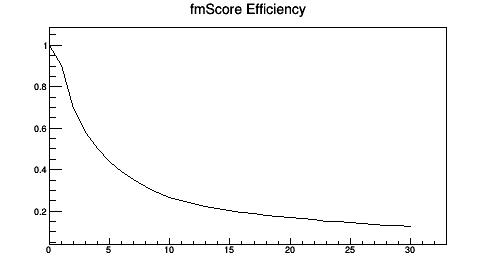

In [25]:
yb = np.linspace(0, 30, 31)

beta = ROOT.TCanvas("beta","2dplot",200,10,500,300)
dy = ROOT.TGraph()
dy.SetTitle("fmScore Efficiency")
for i,fm_cut in enumerate(yb): 
    pcut = (df_ovr1.nu_flash_chi2>fm_cut)
    alpha = np.sum(pcut&cut)
    alpha = float(alpha)
    gamma = np.sum(cut)
    gamma = float(gamma)
    efficiency =  alpha/gamma
    #efficiency = np.sum(pcut&cut) / np.sum(cut)
    #purity = np.sum(pcut&cut) / np.sum(pcut)
    
    dy.SetPoint(i,fm_cut,efficiency)
     
dy.Draw()
beta.Draw()

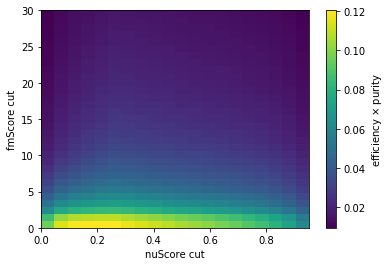

In [26]:
xb = np.linspace(0, 1, 21)[:-1]
yb = np.linspace(0, 30, 31)

pgrid = np.empty(shape=(len(xb), len(yb)), dtype=np.float32)

for i, nu_cut in enumerate(xb):
    for j, fm_cut in enumerate(yb):
        pcut = ((df_ovr1.nu_score>nu_cut)&(df_ovr1.nu_flash_chi2>fm_cut))
        alpha = np.sum(pcut&cut)
        alpha = float(alpha)
        beta = np.sum(cut)
        beta = float(beta)
        gamma = np.sum(pcut)
        gamma = float(gamma)
        efficiency = alpha/beta
        purity =  alpha/gamma
        #efficiency = np.sum(pcut&cut) / np.sum(cut)
        #purity = np.sum(pcut&cut) / np.sum(pcut)
        pgrid[i,j] = efficiency * purity

plt.imshow(pgrid.T, aspect='auto', origin='lower', extent=(xb[0], xb[-1], yb[0], yb[-1]))
cbar = plt.colorbar()
plt.xlabel('nuScore cut')
plt.ylabel('fmScore cut')
cbar.set_label(r'efficiency $\times$ purity')
plt.show()

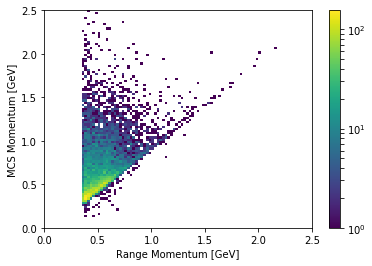

In [98]:
sel = ((df_ovr.track_is_muon_candidate)&
       (df_ovr.mc_neutrino < 1)&
       (df_ovr.mcs_trackLength_rm10 > 100)&
       (df_ovr.mcs_trackMomErr_MuFwd_rm10 < 7.5))

plt.hist2d(df_ovr.track_range_mom_mu[sel], df_ovr.mcs_trackMom_MuFwd_rm10[sel],
           bins=100, range=[[0,2.5],[0,2.5]], norm=col.LogNorm())
plt.colorbar()
plt.xlabel('Range Momentum [GeV]')
plt.ylabel('MCS Momentum [GeV]')
plt.show()

In [27]:
xbins = np.linspace(0, 2, 5)
y = np.empty(shape=len(xbins)-1)
ye = np.empty_like(y)

for i in range(len(xbins)-1):
    p = df_ovr.track_range_mom_mu
    selection = sel & (p >= xbins[i]) & (p < xbins[i+1]) & (df_ovr.mcs_trackMom_MuFwd_rm10>0)
    mcs = df_ovr.mcs_trackMom_MuFwd_rm10[selection]
    rng = df_ovr.track_range_mom_mu[selection]
    delta = (1.0 / mcs - 1.0 / rng) / (1.0 / rng)
    y[i] = np.mean(delta)
    ye[i] = np.std(delta)

x = xbins[:-1] + np.diff(xbins) / 2
plt.errorbar(x, y, ye, np.diff(xbins)/2, 'o', c='red', label='Run 1 overlay')
plt.xlabel(r'$p_{range}$ (GeV)')
plt.ylabel(r'$p^{-1}_\mathrm{MCS}$ fractional bias')
plt.axhline(0, ls='dotted', c='black')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

NameError: name 'sel' is not defined

In [155]:
def makeBiasAndResolPlots(selection,trkMom_MuFwd,trkMom_RangeMu,xmin,xmax,xstp,label,color):
    bins = np.arange(xmin,xmax+xstp,xstp)
    loedges = bins[:-1]
    hiedges = bins[1:]
    #print loedges
    #print hiedges
    hlist = []
    hb = r.TH1F("bias"+label,"",len(loedges),xmin,xmax)
    hr = r.TH1F("resol"+label,"",len(loedges),xmin,xmax)
    hb.GetXaxis().SetTitle("p_{range} [GeV]")
    hr.GetXaxis().SetTitle("p_{range} [GeV]")
    hb.GetYaxis().SetTitle("p_{mcs}^{-1} fractional bias")
    hr.GetYaxis().SetTitle("p_{mcs}^{-1} fractional resolution")
    hb.GetYaxis().SetTitleOffset(1.6)
    hr.GetYaxis().SetTitleOffset(1.6)
    hr.SetLineColor(color)
    hb.SetLineColor(color)
    hr.SetLineColor(color)
    for b in range(0,len(loedges)):
        #print b, loedges[b], hiedges[b]
        abin = selection&(trkMom_RangeMu>=loedges[b])&(trkMom_RangeMu<hiedges[b])
        mcscontb = trkMom_MuFwd[abin]
        rngcontb = trkMom_RangeMu[abin]
        vals = (1./mcscontb - 1./rngcontb)/(1./rngcontb)
        h = r.TH1F(label+"bin"+str(b),label+"bin"+str(b),20,-0.6,0.6)
        for v in vals: h.Fill(v)
        #c = r.TCanvas("c")
        #c.Draw()
        #h.Draw()
        fr = h.Fit("gaus","MESQ","",-0.2,0.2)
        hlist.append(h)
        if int(fr)>0:
            #print fr.GetParams()[0], fr.GetErrors()[0]
            #print fr.GetParams()[1], fr.GetErrors()[1]
            #print fr.GetParams()[2], fr.GetErrors()[2]
            hb.SetBinContent(b+1,fr.GetParams()[1])
            hb.SetBinError(b+1,fr.GetErrors()[1])
            hr.SetBinContent(b+1,fr.GetParams()[2])
            hr.SetBinError(b+1,fr.GetErrors()[2])
    return hb, hr, hlist

Warning in <TROOT::Append>: Replacing existing TH1: biasBNB Overlay Run1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: resolBNB Overlay Run1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: BNB Overlay Run1bin0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: BNB Overlay Run1bin1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: BNB Overlay Run1bin2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: BNB Overlay Run1bin3 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


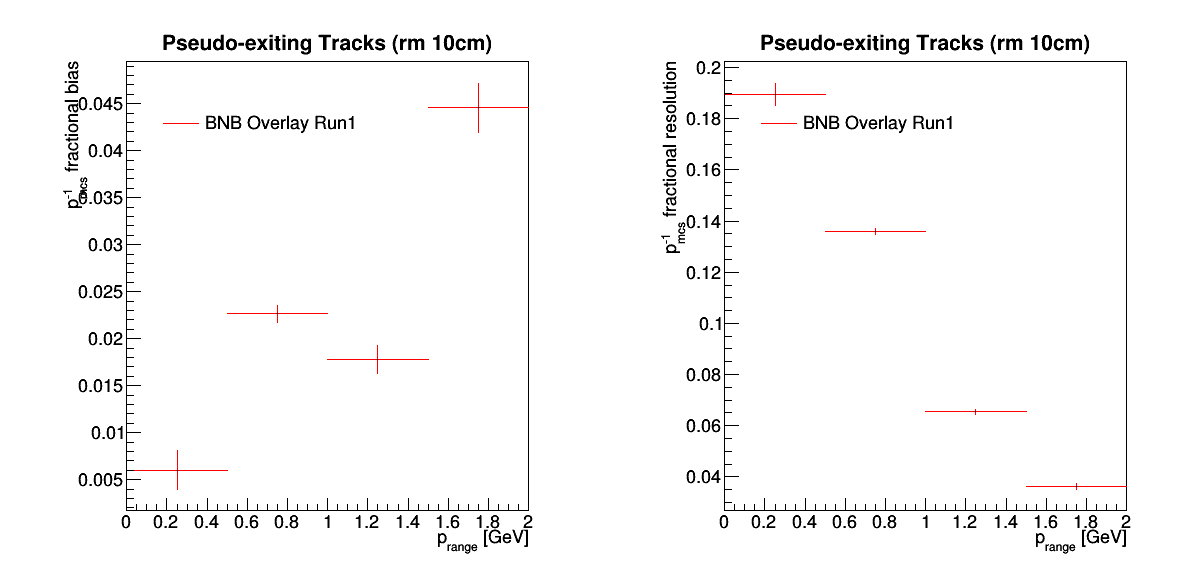

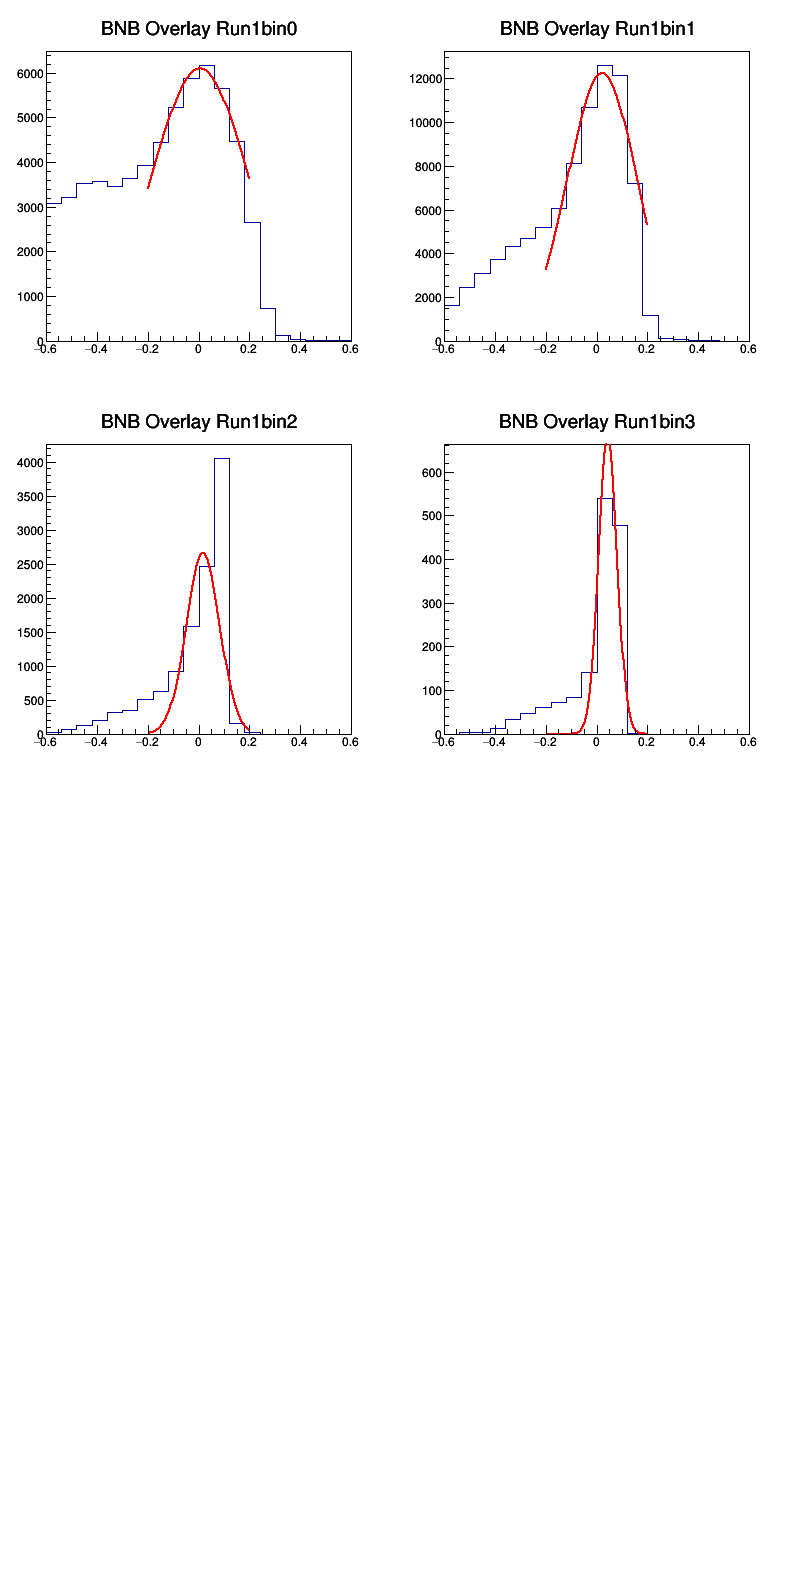

In [161]:
xmin = 0.
xmax = 2.
xstp = 0.5
tag = "Pseudo-exiting Tracks (rm 10cm)"

hb_ovrl, hr_ovrl, hlist_ovrl = makeBiasAndResolPlots(selection_ovrl,trkMom_MuFwd_ovrl,trkMom_RangeMu_ovrl,xmin,xmax,xstp,label_ovrl,r.kRed)

r.gStyle.SetOptStat(0)

leg = r.TLegend(.25,.70,.6,.88)
leg.SetNColumns(1)
leg.SetBorderSize(0)
leg.SetFillColor(0)
leg.SetFillStyle(0)
leg.SetTextFont(42)
leg.SetTextSize(0.035)
leg.AddEntry(hb_ovrl,label_ovrl,"L")

ttext = r.TPaveText(0.20,0.90,0.9,0.96, "NDC")#NDC=relative to pad dimensions
ttext.SetFillColor(0)
ttext.SetTextSize(0.04) 
ttext.SetBorderSize(0)
ttext.AddText(tag)
ttext.Draw()

c = r.TCanvas("c","c",1200,600)
c.Divide(2,1)
c.Draw()
c.cd(1)
r.gPad.SetLeftMargin(0.2)
hb_ovrl.Draw("same")
leg.Draw()
ttext.Draw()
c.cd(2)
r.gPad.SetLeftMargin(0.2)
hr_ovrl.Draw("same")
ttext.Draw()
leg.Draw()

co4 = r.TCanvas("co4","co4",800,1600)
co4.Divide(2,4)
co4.Draw()
for h in range(0,len(hlist_ovrl)):
    co4.cd(h+1)
    hlist_ovrl[h].Draw()
#print len()